# Author Affiliation Analysis 
Categorizing and summarizing the departmental affiliations of authors publishing in the Journal of Cognitive Science.


In [3]:
import pandas as pd
import string as st
import matplotlib
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 

font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 16}

matplotlib.rc('font', **font)

In [4]:
def Consolidate_hex(aff_lst,aff_df,columns):
    # This function loops over the article table and counts how many "points" each category scored.
    # initialize empty hexacount df
    hexaCount=pd.DataFrame(0, index=np.arange(len(aff_df)), columns=columns)
    for i in range(len(aff_df)):
        # NOTE: index 0 of each sublist of lst is the name of that publication type, not a filter term
        if pd.isnull(aff_df.iloc[i]):
            # skip because it's nan
            hexaCount["missing"].iloc[i] = 1
            hexaCount["total"].iloc[i] = hexaCount.iloc[i].sum()
            continue
        
        # this loop iterates over all hexagon categories and add 1 for articles that satisfy
        for j in range(len(aff_lst)):
            for k in range(len(aff_lst[j])):                
                if aff_lst[j][k] in aff_df.iloc[i]:                    
                    hexaCount.iloc[i][aff_lst[j][0]] += 1
                    continue
        
        # append 1 to other if the row is all 0s here
        if hexaCount.iloc[i].sum()<1.:            
                hexaCount["other"].iloc[i] = 1
        
        # get the total number of satisfied hexagon categories
        hexaCount["total"].iloc[i] = hexaCount.iloc[i].sum()
    return hexaCount


def ConsolidateType(lst,df_pd):
    # This function will replace and consolidate all the inconsistent spelling of article types
    oldTypes = df_pd.article_type.values
    newTypes = []
    for i in range(len(oldTypes)):
        # NOTE: index 0 of each sublist of lst is the name of that publication type, not a filter term        
        for j in range(len(lst)):            
            if oldTypes[i] in lst[j][1:]:                
                newTypes.append(lst[j][0])
                break
            elif j == len(lst)-1:                
                newTypes.append(np.nan)
                                
    df_pd.article_type = newTypes

### Load cogsci affiliations data and preprocess

In [5]:
# load dataset as pandas df
data_file = '../data/affiliations_data/cogsci_journal_unprocessed.csv'
df_pd = pd.read_csv(data_file)

# fix the article index column name
df_pd.rename(columns={"Unnamed: 0": "Article Index"}, inplace=True)

# drop all rows where 'article_name' is nan
df_pd = df_pd.dropna(how='all', subset=['article_name'])

# need to realign indices to start at 0
df_pd.index=range(len(df_pd.index))

# sort by year
df_pd = df_pd.sort_values('year')

### Subselect articles by article type (original article, commentary, etc)
Prune articles by subselecting only certain article types, defined by art_types CSV file where each row is a publication type.

In [6]:
# first element of every row is the name of the type, subsequent columns are types to be included
art_types = '../data/affiliations_data/article_types.csv'
df_art_types = pd.read_csv(art_types, sep=',', header= None)

# makes a list of lists where each sublist is an article type. elem 0 is name, rest elements
lst=[[] for _ in range(len(df_art_types))] 

#populates list with csv data
for i in range(df_art_types.shape[1]):
        for j in range(df_art_types.shape[0]):
            lst[j].append(df_art_types[i][j])
            
#removes nan from list of list (it is square by default)           
for a in range(len(lst)):
    lst[a] = [x for x in lst[a] if str(x) != 'nan']

# operate on dataframe directly to consolidate article types
ConsolidateType(lst,df_pd)

# removes unwanted types from our dataset
df_incl_articles = df_pd.dropna(how='any', subset=['article_type'])
df_incl_articles.index=range(len(df_incl_articles.index))

# save out 
df_incl_articles.to_csv("../data/affiliations_data/cogsci_consolidated_types.csv")

# show included article types
print(np.unique(df_incl_articles['article_type']))

['Announcement' 'Brief_Report' 'Comment' 'Commentary' 'Extended_Article'
 'Letter_to_Editor' 'Original_Article' 'Regular_Article' 'Special']


### Making hexagon data (categorize affiliations)

In [9]:
# the hex_def_file defines which are the included subdisciplines in the visualization
# this defines which search words are used for each core discipline

# CHANGE THIS TABLE to use different search words
hex_def_file = '../data/affiliations_data/affiliation_types_core.csv'

# This cell will make arrays of "hexagonal" terms from a csv file
aff_types = pd.read_csv(hex_def_file, sep=',', header=None,encoding='latin-1')


# makes a list of lists where each sublist is a hexagonal type. elem 0 is name, rest elements
aff_lst=[[] for _ in range(len(aff_types))] 

#populates list with csv data
for i in range(aff_types.shape[1]):
        for j in range(aff_types.shape[0]):
            aff_lst[j].append(aff_types[i][j])

#removes nan from list of list (it is square by default)           
for a in range(len(aff_lst)):
    aff_lst[a] = [x for x in aff_lst[a] if str(x) != 'nan']
    
# make additional columns for the final table
columns = []
for cat in aff_lst:
    columns.append(cat[0])

columns.append('other')
columns.append('missing')
columns.append('total')

# print out included types
aff_types.index=aff_types.iloc[:,0]
aff_types.fillna('').T

,anthropology,linguistics,neuroscience,philosophy,psychology,computer science,cognitive science
0,anthropology,linguistics,neuroscience,philosophy,psychology,computer science,cognitive science
1,anthro,linguistic,neuroscience,philosophy,psychology,computer science,cognitive
2,,language,neuro,,psycho,cybernetics,cognitiva
3,,communication,neural,,behavior,computer,
4,,speech,brain,,psicologia,eecs,
5,,,biology,,,technology,
6,,,bio,,,cecs,
7,,,kinesiology,,,parc,
8,,,health,,,informatique,
9,,,physiology,,,informatic,


In [10]:
# Build "Hexagon"
hexaCount = Consolidate_hex(aff_lst, df_incl_articles["author_affiliations"].str.lower(), columns)

# append hexagon to original data and saveout
pd_concat = pd.concat([df_incl_articles, hexaCount], axis=1)
pd_concat.to_csv("../data/affiliations_data/cogsci_consolidated_hexlabeled.csv")

# Visualization of core disciplines

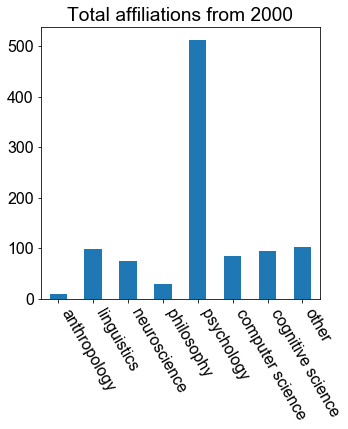

In [12]:
# histogram over all years
# plot hexagon normalized by total (0:-2 indexing to exclude columns missing and total)
years_after = 2000
hex_normed = pd_concat[pd_concat['year']>years_after][columns[:-2]].div(pd_concat[pd_concat['year']>years_after]['total'], axis='rows')
hex_normed.sum().plot(kind='bar', figsize=(5,5))
plt.xticks(rotation=300, horizontalalignment='left')
plt.title('Total affiliations from %i'%years_after);

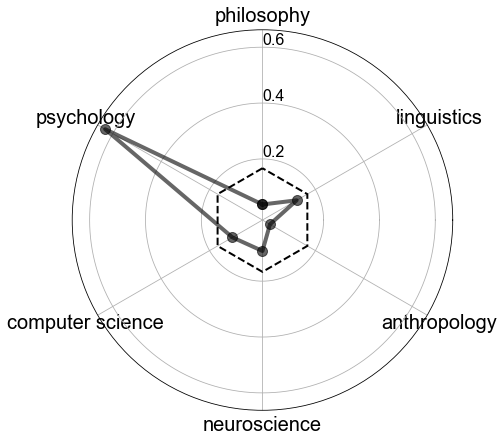

In [23]:
columns_plot = ['philosophy', 'psychology', 'computer science', 'neuroscience','anthropology', 'linguistics']

# get the hexagon
hex_collapsed = hex_normed.sum()[columns_plot]/hex_normed.sum()[columns_plot].sum()

# create the radial points
theta = (np.linspace(0, np.pi*2-np.pi*2/len(hex_collapsed), len(hex_collapsed))+np.pi/2.)%(np.pi*2)
theta_app = np.append(theta, theta[0])
theta_app

# plot
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1, polar=True)
ax.plot(theta_app, np.append(hex_collapsed, hex_collapsed[0]), 'k-o', lw=4, ms=10, alpha=0.6)
# plot uniform distribution
ax.plot(theta_app, np.ones(len(theta)+1)/len(theta), 'k--',lw=2)
ax.set_rticks(np.arange(0.2,0.7,0.2))
ax.set_rlabel_position(90)
ax.set_xticks(theta)
ax.set_xticklabels(hex_collapsed.keys(), fontsize=20);
plt.savefig('../figures/hexagon.pdf')

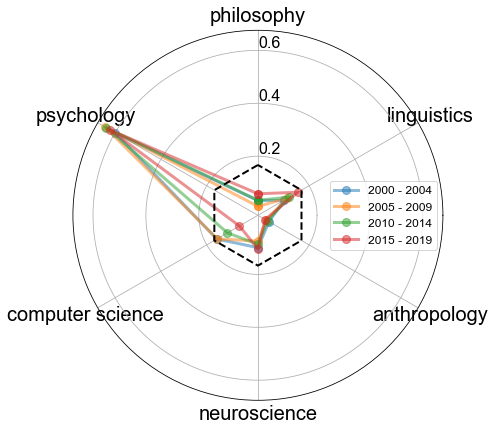

In [16]:
## do hexagon by different years
columns_plot = ['philosophy', 'psychology', 'computer science', 'neuroscience','anthropology', 'linguistics']
year_ranges = [2000, 2005, 2010, 2015, 2020]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1, polar=True)
# create the radial points
theta = (np.linspace(0, np.pi*2-np.pi*2/len(hex_collapsed), len(hex_collapsed))+np.pi/2.)%(np.pi*2)
theta_app = np.append(theta, theta[0])

for i in range(len(year_ranges)-1):
    pd_subset = pd_concat[np.logical_and(pd_concat['year']>=year_ranges[i], pd_concat['year']<year_ranges[i+1])]
    hex_normed_subset = pd_subset[columns[:-2]].div(pd_subset['total'], axis='rows')
    hex_collapsed = hex_normed_subset.sum()[columns_plot]/hex_normed_subset.sum()[columns_plot].sum()    
    # plot
    ax.plot(theta_app, np.append(hex_collapsed, hex_collapsed[0]), '-o', lw=3, ms=8, alpha=0.5, label='%i - %i'%(year_ranges[i],year_ranges[i+1]-1))

plt.legend(loc=7, fontsize=12)

# plot uniform distribution
ax.plot(theta_app, np.ones(len(theta)+1)/len(theta), 'k--',lw=2)
ax.set_xticks(theta)
ax.set_rticks(np.arange(0.2,0.7,0.2))
ax.set_rlabel_position(90)
ax.set_xticklabels(hex_collapsed.keys(), fontsize=20);
plt.tight_layout()
plt.savefig('../figures/hexagon_overtime.pdf')

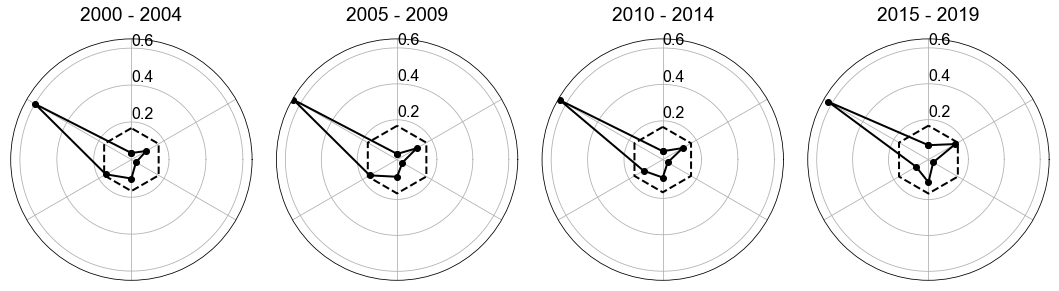

In [17]:
# laid out on different grids
columns_plot = ['philosophy', 'psychology', 'computer science', 'neuroscience','anthropology', 'linguistics']
year_ranges = [2000, 2005, 2010, 2015, 2020]

fig = plt.figure(figsize=(15,4))
# create the radial points
theta = (np.linspace(0, np.pi*2-np.pi*2/len(hex_collapsed), len(hex_collapsed))+np.pi/2.)%(np.pi*2)
theta_app = np.append(theta, theta[0])

for i in range(len(year_ranges)-1):
    ax = fig.add_subplot(1, 4, i+1, polar=True)
    pd_subset = pd_concat[np.logical_and(pd_concat['year']>=year_ranges[i], pd_concat['year']<year_ranges[i+1])]
    hex_normed_subset = pd_subset[columns[:-2]].div(pd_subset['total'], axis='rows')
    hex_collapsed = hex_normed_subset.sum()[columns_plot]/hex_normed_subset.sum()[columns_plot].sum()
    
    # plot
    ax.plot(theta_app, np.append(hex_collapsed, hex_collapsed[0]), '-ko', lw=2, alpha=1)    

    # plot uniform distribution
    ax.plot(theta_app, np.ones(len(theta)+1)/len(theta), 'k--',lw=2)
    ax.set_xticks(theta)
    #ax.set_xticklabels(hex_collapsed.keys(), fontsize=5);    
    ax.set_xticklabels('');
    ax.set_rmax(0.65)
    ax.set_rlabel_position(90)
    ax.set_rticks(np.arange(0.2,0.7,0.2))
    plt.title('%i - %i'%(year_ranges[i],year_ranges[i+1]-1))

plt.tight_layout()

In [18]:
#pd_concat.groupby(pd_concat[pd_concat['year']>years_after]['year']).count().sum()
hex_normed.sum()[columns_plot]/hex_normed.sum()[columns_plot].sum()

philosophy          0.036909
psychology          0.630757
computer science    0.105554
neuroscience        0.092077
anthropology        0.012118
linguistics         0.122584
dtype: float64

(2001, 2017)

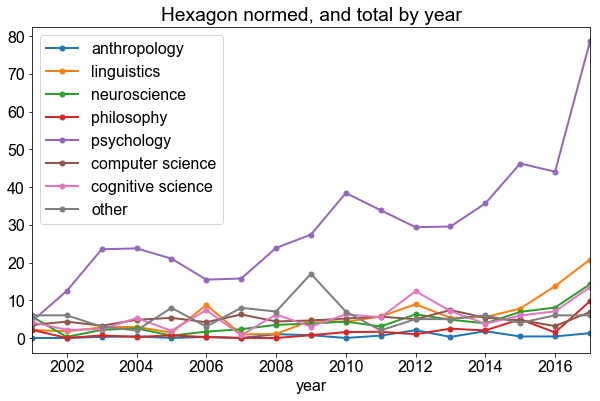

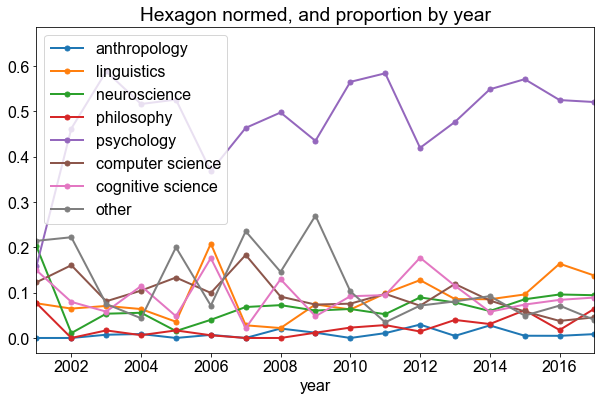

In [19]:
# this plots sum per year, which means it sums to the total # of articles written that year
#hex_normed.groupby(pd_concat['year']).sum().plot(figsize=(12,6))
hex_normed.groupby(pd_concat[pd_concat['year']>years_after]['year']).sum().plot(figsize=(10,6),  marker='o', ms=5, lw=2)
plt.title('Hexagon normed, and total by year')
plt.xlim([2001,2017])

# this plots mean per year, which means it normalizes by the number of articles written per year
#hex_normed[columns_plot].groupby(pd_concat[pd_concat['year']>years_after]['year']).mean().plot(kind='bar', stacked=True, figsize=(12,6))
hex_normed.groupby(pd_concat[pd_concat['year']>years_after]['year']).mean().plot(figsize=(10,6),marker='o', ms=5, lw=2)
plt.title('Hexagon normed, and proportion by year')
plt.legend(loc=2)
plt.xlim([2001,2017])

# Save out hexagon per year for making pretty figures
hex_per_year.csv contains unnormalized counts of each category in each year.

In [21]:
hex_per_year = hex_normed.groupby(pd_concat[pd_concat['year']>2000]['year']).sum()
print(hex_per_year)
hex_per_year.to_csv("../data/affiliations_data/hex_per_year.csv")

        anthropology  linguistics  neuroscience  philosophy  psychology  \
year                                                                      
2001.0      0.000000     2.142857      5.659271    2.150000    4.426299   
2002.0      0.000000     1.750000      0.291667    0.000000   12.475000   
2003.0      0.285714     2.827381      2.141667    0.666667   23.515476   
2004.0      0.400000     2.934524      2.557540    0.285714   23.743254   
2005.0      0.000000     1.433333      0.611111    0.666667   21.033333   
2006.0      0.285714     8.744048      1.683333    0.250000   15.461905   
2007.0      0.000000     0.950000      2.321429    0.000000   15.757143   
2008.0      1.000000     1.050000      3.477381    0.000000   23.876190   
2009.0      0.733333     4.666667      3.809524    0.733333   27.395238   
2010.0      0.000000     4.273810      4.344444    1.555556   38.419048   
2011.0      0.619048     5.694048      3.042857    1.650000   33.865476   
2012.0      2.066667     